# Segment anything model workbench
This notebook provides a small example to get started with the SAM. It is currently tested on an Apple M1 Max.

The model repository is here https://github.com/facebookresearch/segment-anything

Cite the model using

@article{kirillov2023segany,
  title={Segment Anything},
  author={Kirillov, Alexander and Mintun, Eric and Ravi, Nikhila and Mao, Hanzi and Rolland, Chloe and Gustafson, Laura and Xiao, Tete and Whitehead, Spencer and Berg, Alexander C. and Lo, Wan-Yen and Doll{\'a}r, Piotr and Girshick, Ross},
  journal={arXiv:2304.02643},
  year={2023}
}

## Installation instructions
```bash
conda install pytorch torchvision torchaudio -c pytorch-nightly
conda install opencv
pip install git+https://github.com/facebookresearch/segment-anything.git
```

You also have to download the [model check point](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth). The path to the checkpoint must be adjusted. In this notebook I used the path ```./sam-model/sam_vit_h_4b8939.pth```.


# Using the model
## Import needed modules

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import ipywidgets as widgets

%matplotlib widget

## Import the SAM module

In [65]:
# Import SAM modules from the repository (ensure your PYTHONPATH is set up correctly)
from segment_anything import sam_model_registry, SamPredictor

## Prepare SAM

In [66]:
# Specify the SAM model type and the path to your checkpoint file
sam_checkpoint = "./sam-model/sam_vit_h_4b8939.pth"  # Replace with your checkpoint path
model_type = "vit_h"  # Options: "vit_h", "vit_l", or "vit_b"

### Detect if Apple's MPS backend is available (for M1/M2 chips)

In [67]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
else:
    # Fallback to CUDA if available, otherwise CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", device)

Using device: mps


### Initialize SAM
Load the SAM model and move it to the appropriate device. This takes some seconds.

In [68]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Create the predictor object
predictor = SamPredictor(sam)

# Set the image for the predictor
predictor.set_image(image)

## Load a test image

In [69]:
# Load and prepare your image (replace with your image path)
image_path = "data/lump.png"
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found. Please check the path.")
# Convert image from BGR (OpenCV default) to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

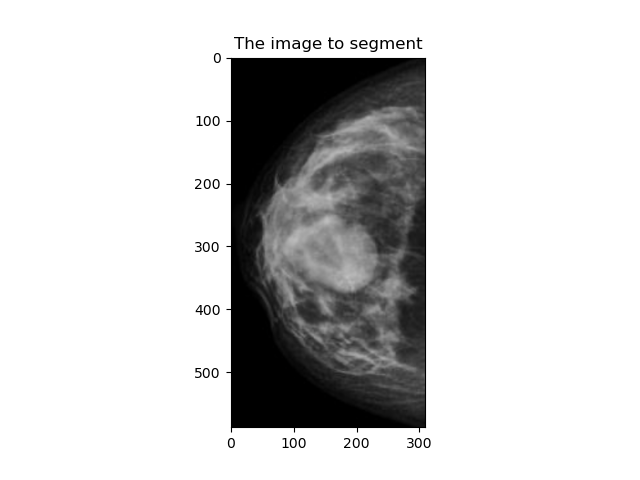

In [73]:
fig,ax = plt.subplots(1)
ax.imshow(image)
ax.set_title("The image to segment")
plt.show()

In [75]:
# This function is intended for selecting markers in the image. It doesn't work :-(
# def get_points(image):
#     plt.imshow(image)
#     plt.title("Click on points. Press Enter when done.")
#     plt.show()
#     # Use plt.ginput to interactively select points on the image.
#     # n=-1 allows unlimited clicks until the Enter key is pressed.
#     selected_points = plt.ginput(n=-1, timeout=0)
#     plt.close()  # Close the plot window when done

#     # Convert the selected points list into a NumPy array
#     points_array = np.array(selected_points)
#     return points_array

# points_array=get_points(image)
# print("Selected points (x, y):")
# print(points_array)

## Add markers
The markers here are manually selected. You need two lists
1. The coordinates
2. The asociated classes

I tried having three classes but that was confising for the model. These are the commented lines in the lists.

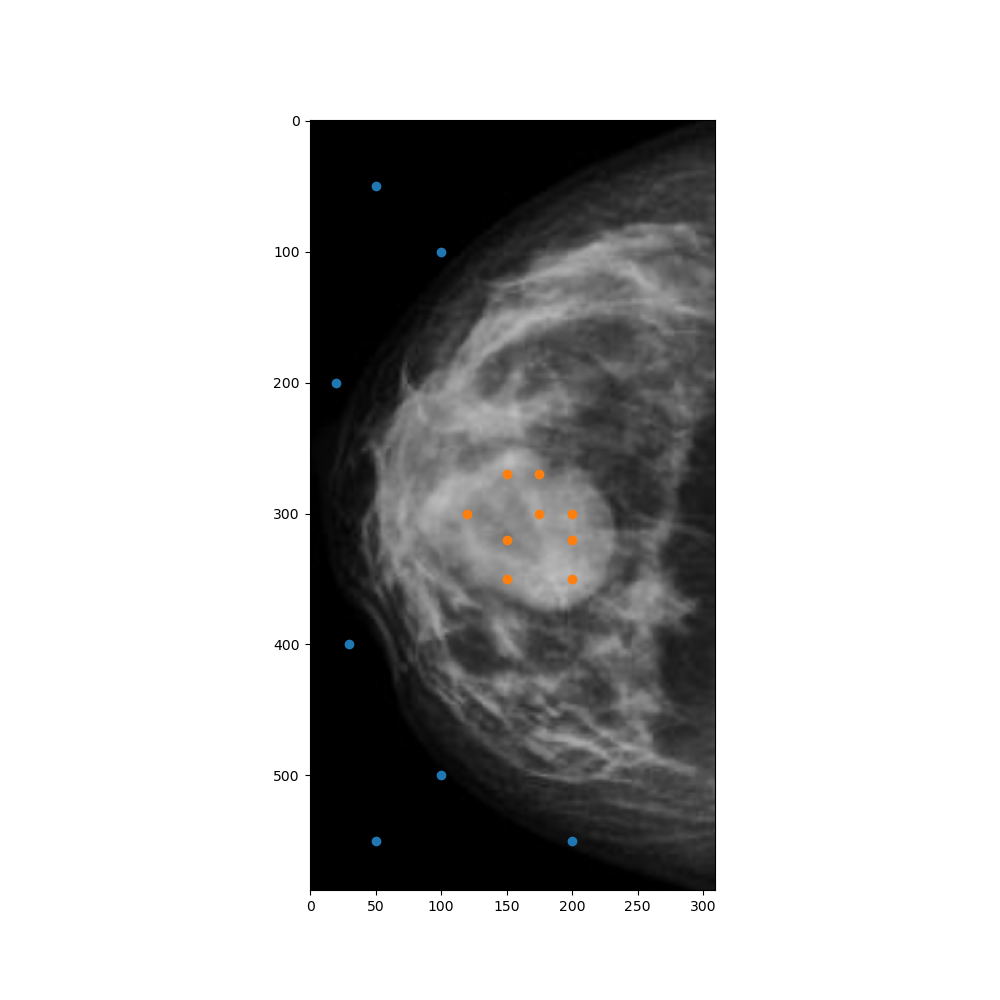

In [59]:
input_point = np.array([[120, 300],[150,270],[200,320],[175,270],[200,300],[175,300],[150,320],[200,350],[150,350],
#                       [100,400],[200,420],[250,450],[200,200],[250,450],[125,370],[125,100],[40,300],[250,550],[280,400],[125,410],[125,220],
                        [100,100],[20,200],[30,400],[100,500],[200,550],[50,50],[50,550]])  # Coordinates (x, y)

input_label = np.array([2,2,2,2,2,2,2,2,2,
#                         1,1,1,1,1,1,1,1,1,1,1,1,
                        0,0,0,0,0,0,0])           # Label 1 for foreground

fig,ax = plt.subplots(1,figsize=[10,10])
ax.imshow(image)

for c in np.unique(input_label) :
    s=input_point[input_label==c]
    ax.plot(s[:,0],s[:,1],'o')
    
plt.show()

## Run the segmentation
Here, we run the segmention and show the result

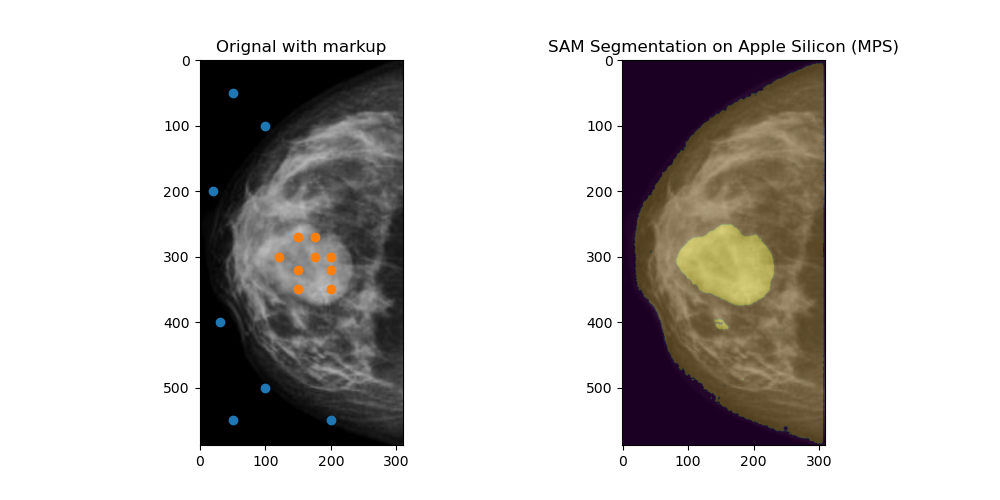

In [61]:
# Run prediction (multimask_output=True returns multiple candidate masks)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Select the mask with the highest confidence score
best_mask = masks[np.argmax(scores)]
fig,ax = plt.subplots(1,2,figsize=(10,5))
# Visualize the segmentation result by overlaying the mask on the original image

ax[0].imshow(image)

for c in np.unique(input_label) :
    s=input_point[input_label==c]
    ax[0].plot(s[:,0],s[:,1],'o')

ax[0].set_title('Orignal with markup')

ax[1].imshow(image)
cmap='viridis'
ax[1].imshow(masks[0], alpha=0.25, cmap=cmap)
ax[1].imshow(masks[2], alpha=0.25, cmap=cmap)
ax[1].set_title("SAM Segmentation on Apple Silicon (MPS)")


plt.show()

### The segmented mask
Here are the individial masks shown.

(-0.5, 309.5, 587.5, -0.5)

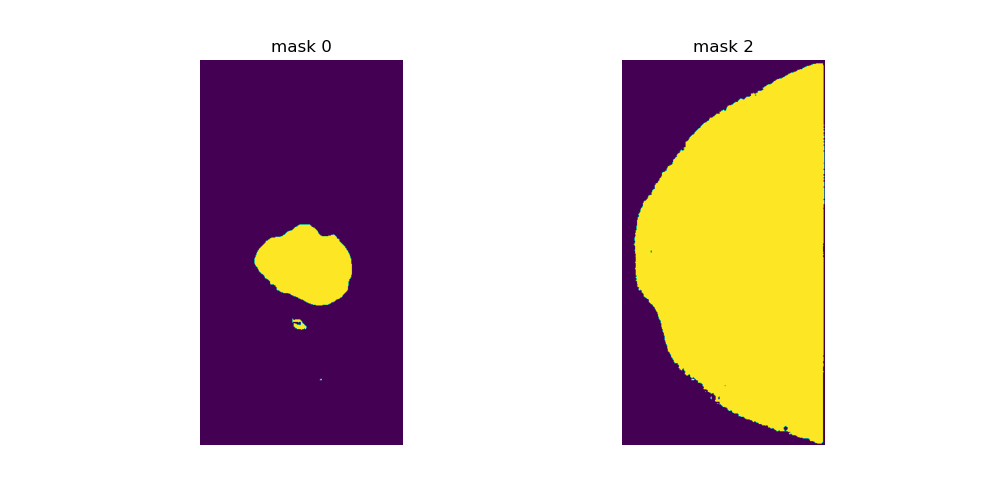

In [77]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
x=masks
ax[0].imshow(x[0])
ax[0].set_title('mask 0')
ax[0].axis('off')

# ax[1].imshow(x[1])
# ax[1].set_title('mask 1')
# ax[1].axis('off')

ax[1].imshow(x[2])
ax[1].set_title('mask 2')
ax[1].axis('off')

# Conclusion 
This was a very short example to test the SAM model. It demonstrates how a segmentation can be configured an run with very little effort. My experience so far is that it is important to provide sufficient markers for best performance. 

The SAM 1.0 is mainly intended for 2D images and needs the markers to identify where the relevant regions are.